In [3]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\DevelopKit\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
import sys
sys.path.append('../lib')

import XgbAdjustmentHelper as xgbhelper
import SklearnModelCurve as curve_helper

In [6]:
munged_train_df = pd.read_csv('../data/offline/train.csv', index_col=0)
munged_test_df = pd.read_csv('../data/offline/test.csv', index_col=0)
y_train_df = pd.read_csv('../data/offline/y_train.csv', index_col=0)

X_train, X_test, y_train, y_test = train_test_split(munged_train_df.values, y_train_df.values, test_size=0.5, random_state=1729)
X_all_train = munged_train_df.values
y_all_train = y_train_df['y'].values

In [7]:
feature_names = munged_train_df.columns

In [8]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [16]:
def objective(params):
    print("Training with params : ")
    print(params)
    params['max_depth'] = np.int(params['max_depth'])
    num_boost_round = 1000;
    early_stopping_rounds = 50;
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_boost_round = num_boost_round)
    y_predict = model.predict(dvalid)
    score = r2_score(y_test, y_predict)
    loss = 1- score
    print("\tScore {0}\n\n".format(score))
    return {'loss': loss, 'status': STATUS_OK}

def optimize():
    space = {
             'eta' : hp.uniform('eta', 0.005, 0.1),
             'max_depth' : 4,
             'min_child_weight' : hp.quniform('min_child_weight', 1, 9, 2),
             'subsample' : hp.quniform('subsample', 0.8, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0, 0.5, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.8, 1, 0.05),
             #'eval_metric': 'mlogloss',
             'objective': 'reg:linear',
             'silent' : 1,
             }

    best = fmin(objective, space, algo=tpe.suggest, max_evals=250)
    return best;

best = optimize()

Training with params : 
{'gamma': 0.30000000000000004, 'min_child_weight': 6.0, 'silent': 1, 'eta': 0.05695498918603504, 'colsample_bytree': 0.8, 'max_depth': 4, 'subsample': 0.8, 'objective': 'reg:linear'}
	Score 0.45299659587375385


Training with params : 
{'gamma': 0.0, 'min_child_weight': 8.0, 'silent': 1, 'eta': 0.07356903861762543, 'colsample_bytree': 0.8500000000000001, 'max_depth': 4, 'subsample': 0.8, 'objective': 'reg:linear'}
	Score 0.4447820816302146


Training with params : 
{'gamma': 0.4, 'min_child_weight': 6.0, 'silent': 1, 'eta': 0.019211810181716013, 'colsample_bytree': 0.8, 'max_depth': 4, 'subsample': 1.0, 'objective': 'reg:linear'}
	Score 0.48573994969361045


Training with params : 
{'gamma': 0.2, 'min_child_weight': 4.0, 'silent': 1, 'eta': 0.0865833028017527, 'colsample_bytree': 0.8, 'max_depth': 4, 'subsample': 0.8, 'objective': 'reg:linear'}
	Score 0.44843301992520934


Training with params : 
{'gamma': 0.05, 'min_child_weight': 2.0, 'silent': 1, 'eta': 0.083

In [17]:
best

{'colsample_bytree': 1.0,
 'eta': 0.006254142637712849,
 'gamma': 0.4,
 'min_child_weight': 6.0,
 'subsample': 0.8500000000000001}

In [1]:
def ModelLearnRateSearch(params, learning_rates, num_bounds):
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgb_model = xgb.XGBRegressor()
    xgb_model.set_params(**params)
    best_score = 0
    best_params = {}
    
    for lr in learning_rates:
        
        params['learning_rate'] = lr
        cvresult = xgb.cv(params, xgtrain, num_boost_round=num_bounds, nfold=5,
                          metrics='rmse', early_stopping_rounds=50)
        
        valid_round = cvresult.shape[0]
        xgb_model.set_params(n_estimators = cvresult.shape[0], learning_rate = lr)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)
        score = r2_score(y_test, y_pred)
        print("lr:%f  n_estimators:%d  score:%f\n"%(lr, valid_round, score))
        if best_score < score:
            best_score = score
            best_params['n_estimators'] = valid_round
            best_params['learning_rate'] = lr
            
        print(xgb_model.get_params())
    return best_score, best_params

In [2]:
def KFoldCV(model, num_fold, X_train, y_train):
    cv_results = []
    kf = KFold(n_splits=num_fold, random_state=27)
    for train_index, test_index in kf.split(X_train):
        X_sub_train = X_train[train_index]
        X_sub_test = X_train[test_index]
        y_sub_train = y_train[train_index]
        y_sub_test = y_train[test_index]
        model.fit(X_sub_train, y_sub_train)
        y_pred = model.predict(X_sub_test)
        score = r2_score(y_sub_test, y_pred)
        cv_results.append(score)
    print('mean:%f std:%f'%(np.mean(cv_results), np.std(cv_results)))

In [9]:
init_param = {
    'silent':True,
    'objective':'reg:linear',
    'seed':27,
    'max_depth':4,
}

adjust_param1 = {
    'learning_rate':[0.05, 0.01, 0.005],
    'n_estimators':[500, 700, 1000, 1300],
}


adjust_param2 = {
    'min_child_weight':[1, 3, 8],
}

adjust_param3 = {
    'subsample':[i/100.0 for i in range(85, 105, 5)],
    'colsample_bytree':[i/100.0 for i in range(85, 105, 5)],
}

adjust_param4 = {
    'reg_alpha':[1e-5, 1e-3,1e-1, 10],
}


adjust_params = [adjust_param1, adjust_param2, adjust_param3, adjust_param4]


# init_param = {
#     'learning_rate':0.1,
#     'n_estimators':100,
#     'silent':False,
#     'objective':'reg:linear',
#     'seed':27,
    
#     'min_child_weight':6,
#     'subsample':1,
#     'colsample_bytree':0.9,
#     'gamma':0
# }

# adjust_param = {
#     'max_depth':[3, 4],
# }

xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**init_param)

combine_param = dict(init_param)

for params in adjust_params:
    
    search = xgbhelper.ModelParamSearch(xgb_model, params, X_all_train, y_all_train, 'r2')
    xgb_model.set_params(**search.best_params_)
    combine_param.update(search.best_params_)

score, params = ModelLearnRateSearch(combine_param, [0.1, 0.05, 0.01, 0.005], 5000)
combine_param['n_estimators'] = params['n_estimators']
combine_param['learning_rate'] = params['learning_rate']
xgb_model.set_params(**combine_param)



grid_scores
mean: 0.51095, std: 0.06558, params: {'n_estimators': 500, 'learning_rate': 0.05}
mean: 0.49867, std: 0.06403, params: {'n_estimators': 700, 'learning_rate': 0.05}
mean: 0.48692, std: 0.05940, params: {'n_estimators': 1000, 'learning_rate': 0.05}
mean: 0.47871, std: 0.05628, params: {'n_estimators': 1300, 'learning_rate': 0.05}
mean: 0.54479, std: 0.07623, params: {'n_estimators': 500, 'learning_rate': 0.01}
mean: 0.54256, std: 0.06931, params: {'n_estimators': 700, 'learning_rate': 0.01}
mean: 0.53755, std: 0.06813, params: {'n_estimators': 1000, 'learning_rate': 0.01}
mean: 0.53225, std: 0.06793, params: {'n_estimators': 1300, 'learning_rate': 0.01}
mean: 0.12989, std: 0.13781, params: {'n_estimators': 500, 'learning_rate': 0.005}
mean: 0.49429, std: 0.10099, params: {'n_estimators': 700, 'learning_rate': 0.005}
mean: 0.54492, std: 0.07637, params: {'n_estimators': 1000, 'learning_rate': 0.005}
mean: 0.54418, std: 0.07040, params: {'n_estimators': 1300, 'learning_rate': 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=4, min_child_weight=8, missing=None,
       n_estimators=109, nthread=-1, objective='reg:linear', reg_alpha=10,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9)

In [ ]:
# xgb_model.set_params(**{'learning_rate': 0.05, 'n_estimators': 100})

In [10]:
KFoldCV(xgb_model, 5, X_all_train, y_all_train)

mean:0.549802 std:0.072415


In [22]:
mean:0.501655 std:0.100346
        
mean:0.553034 std:0.076691
mean:0.555594 std:0.076734
mean:0.553807 std:0.077252
mean:0.556646 std:0.078663

SyntaxError: invalid syntax (<ipython-input-22-501cf5276e53>, line 1)

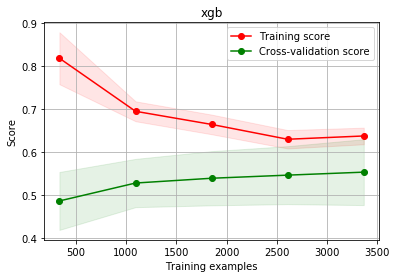

In [15]:
curve_helper.plot_learning_curve(xgb_model, 'xgb', X_all_train, y_all_train, cv=5)

In [16]:
xgb_model.fit(X_all_train, y_all_train)
y_pred = xgb_model.predict(munged_test_df.values)
output = pd.DataFrame({'id': munged_test_df.index, 'y': y_pred})
output.to_csv('../data/online/xgboost-pca-ica-grp-srp-6-10-4.csv', index=False)

In [22]:
y_pred

array([ 69.72631073,  83.14871979,  70.18686676, ...,  82.90158844,
        98.74907684,  83.40969849], dtype=float32)